### Vishnu Nair
### 5 MCA A 
### 2347131
### NNDL ETE

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
import matplotlib.pyplot as plt

In [6]:
# Step 1: Load the dataset
data = pd.read_csv("weather_data.csv")  # Replace with your file name
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

In [7]:
# Step 2: Preprocess the data
# Normalize the temperature column
scaler = MinMaxScaler()
data['tempnormalize'] = scaler.fit_transform(data[['temperature']])

# Split into training and testing sets
traindata, testdata = train_test_split(data['tempnormalize'], test_size=0.3, shuffle=False)

# Create sequences for LSTM
def createseq(data, seqlen):
    sequences = []
    for i in range(len(data) - seqlen):
        seq = data[i : i + seqlen]
        sequences.append(seq)
    return np.array(sequences)

seqlen = 30  # Define the sequence length
trainseq = createseq(traindata.values, seqlen)
testseq = createseq(testdata.values, seqlen)

# Reshape for LSTM input
trainseq = trainseq.reshape(trainseq.shape[0], seqlen, 1)
testseq = testseq.reshape(testseq.shape[0], seqlen, 1)

In [8]:
# Step 3: Build the LSTM Autoencoder
inputdim = trainseq.shape[2]
inputs = Input(shape=(seqlen, inputdim))

# Encoder
encoded = LSTM(64, activation="relu", return_sequences=False)(inputs)
latent = Dense(16, activation="relu")(encoded)

# Decoder
decoded = RepeatVector(seqlen)(latent)
decoded = LSTM(64, activation="relu", return_sequences=True)(decoded)
outputs = TimeDistributed(Dense(inputdim))(decoded)

# Define the Autoencoder model
autoencoder = Model(inputs, outputs)
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 30, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 64)         │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 30, 1)          │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,737 (151.32 KB)

 Trainable params: 38,737 (151.32 KB)

 Non-trainable params: 0 (0.00 B)

Layer Information:
The model starts with an input layer taking sequences of 30 timesteps with 1 feature each.

The LSTM layer reduces the input to 64 dimensions.

A Dense layer compresses it further to 16 latent dimensions.

The RepeatVector expands the latent representation back to 30 timesteps.

A second LSTM layer reconstructs sequences with 64 dimensions.
The TimeDistributed layer outputs the final 30-timestep sequence with 1 feature.



Parameters:

The model has 38,737 trainable parameters, meaning this is the total number of values updated during training.
Purpose:

The encoder compresses data into a smaller representation.

The decoder reconstructs the input to detect anomalies when reconstruction fails.







In [9]:
# Step 4: Train the model
history = autoencoder.fit(
    trainseq, 
    trainseq, 
    epochs=20, 
    batch_size=32, 
    validation_split=0.1, 
    verbose=1
)


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 0.1628 - val_loss: 0.0194
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0141 - val_loss: 0.0091
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0073 - val_loss: 0.0039
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0

In [10]:
# Step 5: Anomaly Detection
# Predict and calculate reconstruction errors
reconstructedtrain = autoencoder.predict(trainseq)
reconstructedtest = autoencoder.predict(testseq)

train_loss = np.mean(np.power(trainseq - reconstructedtrain, 2), axis=(1, 2))
testloss = np.mean(np.power(testseq - reconstructedtest, 2), axis=(1, 2))

# Define anomaly threshold
threshold = np.percentile(train_loss, 95)  # Set threshold as the 95th percentile of train reconstruction errors

# Detect anomalies in the test set
anomalies = testloss > threshold

55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


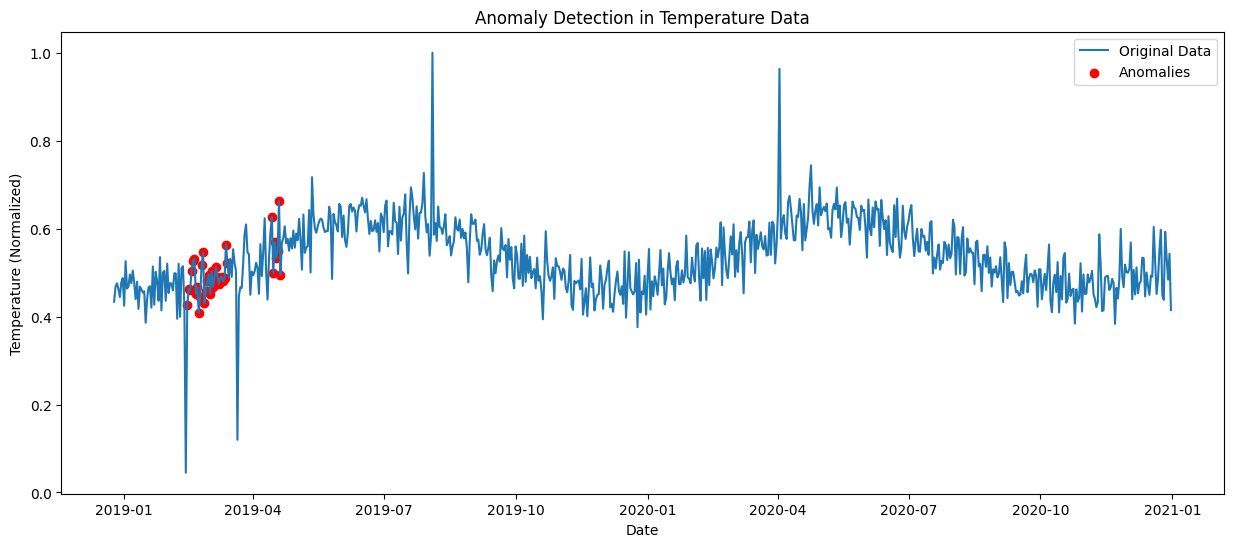

In [11]:
# Step 6: Visualize Results
plt.figure(figsize=(15, 6))
plt.plot(data.index[-len(testloss):], testdata.values[seqlen:], label="Original Data")
plt.scatter(
    data.index[-len(testloss):][anomalies], 
    testdata.values[seqlen:][anomalies], 
    color="red", 
    label="Anomalies"
)
plt.xlabel("Date")
plt.ylabel("Temperature (Normalized)")
plt.title("Anomaly Detection in Temperature Data")
plt.legend()
plt.show()


INTERPRETATION:

The plot shows the temperature data over time (blue line) with detected anomalies highlighted in red. Anomalies are days where the reconstruction error of the LSTM Autoencoder exceeds the defined threshold, indicating unusual temperature patterns. These could signify significant deviations or irregularities in the weather.

Seasonality: The overall temperature pattern exhibits regular fluctuations, possibly reflecting seasonal changes (e.g., colder winters and warmer summers).

Anomalies Clustered: Most anomalies (red dots) are concentrated around early 2019. This suggests a period of unusual or erratic temperature readings, potentially caused by extreme weather events or data recording errors.

Peak Events: The sharp spikes (e.g., mid-2019 and early 2020) are not marked as anomalies, indicating the model identified them as part of expected variability based on training data.